In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import ConvNeXtLarge
from tensorflow.keras.layers import Dropout, GlobalAveragePooling2D, Dense, Input, BatchNormalization, Flatten, Normalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import backend as K

In [2]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
data_dir = "../dataset-original"

In [4]:
# To Reproduce result
tf.random.set_seed(42)
np.random.seed(42)
img_height, img_width = 224, 224
batch_size  =32
num_epochs = 400


# Why 42?
# "Answer to the Ultimate Question of Life" from The Hitchhiker's Guide to the Galaxy

In [5]:
ImageDataGenerator?

Init signature:
ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    zca_epsilon=1e-06,
    rotation_range=0,
    width_shift_range=0.0,
    height_shift_range=0.0,
    brightness_range=None,
    shear_range=0.0,
    zoom_range=0.0,
    channel_shift_range=0.0,
    fill_mode='nearest',
    cval=0.0,
    horizontal_flip=False,
    vertical_flip=False,
    rescale=None,
    preprocessing_function=None,
    data_format=None,
    validation_split=0.0,
    interpolation_order=1,
    dtype=None,
)
Docstring:     
Generate batches of tensor image data with real-time data augmentation.

Deprecated: `tf.keras.preprocessing.image.ImageDataGenerator` is not
recommended for new code. Prefer loading images with
`tf.keras.utils.image_dataset_from_directory` and transforming the output
`tf.data.Dataset` with preprocessing layers. For more information, see the
tutoria

### Preprocessing

    Rescale: Normalize pixel values to the range [0, 1] to aid model convergence

### Augmentation

    1) Shear Range: Introduce deformations up to 20 degrees to introduce deformations for robustness such as shaky pictures.
    
    2) Zoom Range: Randomly zoom in/out by 20% to simulate varying object scales in images.
       
    3) Horizontal Flip: Enable random horizontal flipping for different camera angle variations.

    4) Vertical Flip: Enable random vertical flipping for different camera angle variations.
       
    5) Rotation Range: Rotate images up to 40 degrees to mimic real world camera angle variations. 
    
    6) Width Shift Range: Shift images horizontally to mimic real world camera angle variations.  
    
    7) Height Shift Range: Shift images vertically to mimic real world camera angle variations.  
    
    8) Brightness Range: Adjust brightness between 0.5 and 1.5 times to adapt to diverse lighting conditions.  
    
    9) Channel Shift Range: Shift color channels to introduce color variations for robustness (different camera specification such as RGB vs SRGB.

In [6]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.5, 1.5],
    channel_shift_range=20,
    validation_split=0.2
)

In [7]:
ImageDataGenerator.flow_from_directory?

Signature:
ImageDataGenerator.flow_from_directory(
    self,
    directory,
    target_size=(256, 256),
    color_mode='rgb',
    classes=None,
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=None,
    save_to_dir=None,
    save_prefix='',
    save_format='png',
    follow_links=False,
    subset=None,
    interpolation='nearest',
    keep_aspect_ratio=False,
)
Docstring:
Takes the path to a directory & generates batches of augmented data.

Args:
    directory: string, path to the target directory. It should contain
      one subdirectory per class. Any PNG, JPG, BMP, PPM or TIF images
      inside each of the subdirectories directory tree will be included
      in the generator. See [this script](
      https://gist.github.com/fchollet/0830affa1f7f19fd47b06d4cf89ed44d)
      for more details.
    target_size: Tuple of integers `(height, width)`, defaults to `(256,
      256)`. The dimensions to which all images found will be resized.
    color_mode: One of 

In [8]:
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True,
    class_mode='categorical', # this is for 2D one-hot encoded labels
    subset='training'
)

# this is for 2D one-hot encoded labels

Found 2024 images belonging to 6 classes.


In [9]:
validation_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True,
    class_mode='categorical',
    subset='validation'
)

Found 503 images belonging to 6 classes.


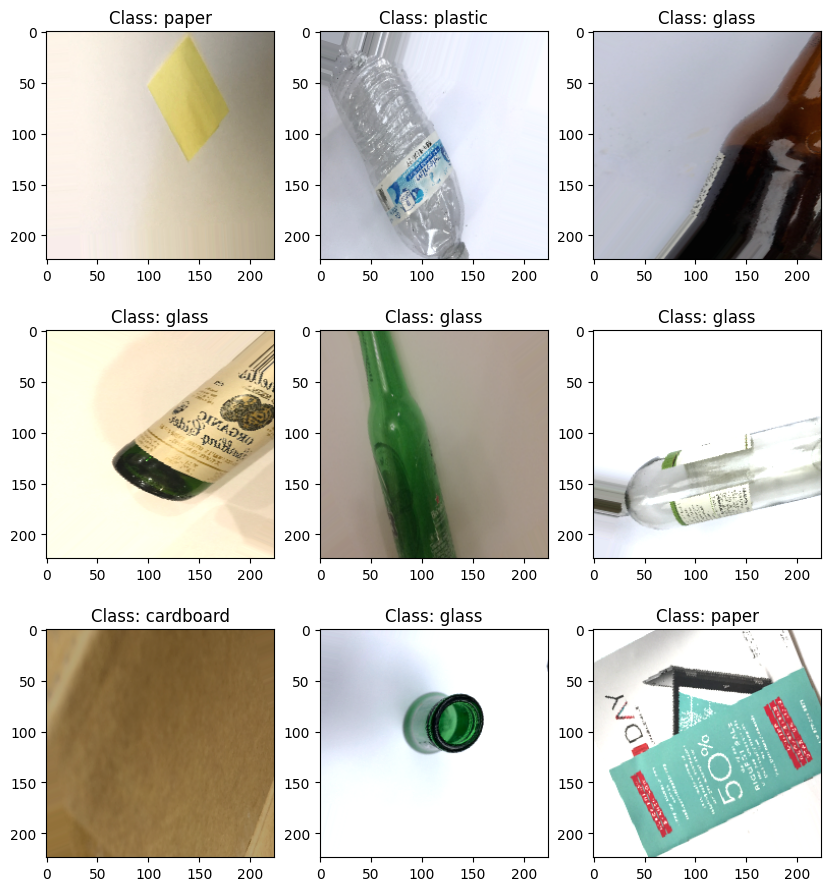

In [10]:
sample_images, sample_labels = next(train_generator)
class_names = list(train_generator.class_indices.keys())

fig, axs = plt.subplots(3, 3, figsize=(10, 11))

for i, ax in enumerate(axs.flat):
   ax.imshow(sample_images[i])
   class_index = np.argmax(sample_labels[i])
   class_name = class_names[class_index]
   ax.set_title(f"Class: {class_name}")

plt.show()

In [11]:
from sklearn.utils.class_weight import compute_class_weight
class_labels = np.unique(train_generator.classes)
class_weights = compute_class_weight('balanced', classes=class_labels, y=train_generator.classes)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
print(class_weight_dict)

{0: 1.04437564499484, 1: 0.8412302576891105, 2: 1.0284552845528456, 3: 0.7086834733893558, 4: 0.8739205526770294, 5: 3.066666666666667}


####  Weightage during training

    1) Class 0 (Cardboard): Slightly up-weighted.  
    
    2) Class 1 (Glass): Down-weighted.  
    
    3) Class 2 (Metal): Slightly up-weighted.  
    
    4) Class 3 (Paper): Down-weighted.

    5) Class 4 (Plastic): Down-weighted.
    
    6) Class 5 (Trash): Significantly up-weighted.  

In [12]:
input_shape = (img_height, img_width, 3)
inputs = Input(shape=input_shape)

base_model = ConvNeXtLarge(weights='imagenet', include_top=False, input_shape=input_shape)

splitter = len(base_model.layers) - 25

for layer in base_model.layers[:splitter]:
    layer.trainable = False

for layer in base_model.layers[splitter:]:
    layer.trainable = True

pd.set_option('max_colwidth', 1)
layers = [(layer, layer.name, layer.trainable) for layer in base_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at 0x0000012BFAE100A0>,input_2,False
1,<keras.layers.preprocessing.normalization.Normalization object at 0x0000012B88140820>,convnext_large_prestem_normalization,False
2,<keras.engine.sequential.Sequential object at 0x0000012B87200B20>,convnext_large_stem,False
3,<keras.layers.convolutional.conv2d.Conv2D object at 0x0000012B9497B040>,convnext_large_stage_0_block_0_depthwise_conv,False
4,<keras.layers.normalization.layer_normalization.LayerNormalization object at 0x0000012B949C8490>,convnext_large_stage_0_block_0_layernorm,False
...,...,...,...
290,<keras.layers.core.dense.Dense object at 0x0000012C00280940>,convnext_large_stage_3_block_2_pointwise_conv_2,True
291,<keras.applications.convnext.LayerScale object at 0x0000012C00280310>,convnext_large_stage_3_block_2_layer_scale,True
292,<keras.layers.core.activation.Activation object at 0x0000012C00240130>,convnext_large_stage_3_block_2_identity,True
293,<keras.layers.core.tf_op_layer.TFOpLambda object at 0x0000012C00245820>,tf.__operators__.add_35,True


In [13]:
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D(name="avg_pool")(x)
x = BatchNormalization()(x)
x = Flatten()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
outputs = Dense(len(train_generator.class_indices), activation='softmax')(x)

# Combine the base model with custom top layers
model = Model(inputs=inputs, outputs=outputs)

In [14]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

#print the summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 convnext_large (Functional)  (None, 7, 7, 1536)       196230336 
                                                                 
 avg_pool (GlobalAveragePool  (None, 1536)             0         
 ing2D)                                                          
                                                                 
 batch_normalization (BatchN  (None, 1536)             6144      
 ormalization)                                                   
                                                                 
 flatten (Flatten)           (None, 1536)              0         
                                                                 
 dense (Dense)               (None, 256)               393472

In [15]:
checkpoint_dir = './ConvNeXtLarge_checkpoints/'
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_filepath = os.path.join(checkpoint_dir, 'model_checkpoint_{epoch:02d}.h5')

model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

early_stopping_callback = EarlyStopping(
    monitor='val_accuracy',
    patience=15,
    mode='max',
    restore_best_weights=True,
    verbose=1
)

callbacks = [model_checkpoint_callback, early_stopping_callback]

In [16]:
history = model.fit(
    train_generator,
    epochs=400,
    validation_data=validation_generator,
    class_weight=class_weight_dict,
    workers = 8,
    callbacks=[model_checkpoint_callback, early_stopping_callback]
)

Epoch 1/400
64/64 [==============================] - ETA: 0s - loss: 2.1996 - accuracy: 0.1798
Epoch 1: val_accuracy improved from -inf to 0.16103, saving model to ./ConvNeXtLarge_checkpoints\model_checkpoint_01.h5
64/64 [==============================] - 128s 1s/step - loss: 2.1996 - accuracy: 0.1798 - val_loss: 1.9935 - val_accuracy: 0.1610
Epoch 2/400
64/64 [==============================] - ETA: 0s - loss: 1.9223 - accuracy: 0.2589
Epoch 2: val_accuracy improved from 0.16103 to 0.17495, saving model to ./ConvNeXtLarge_checkpoints\model_checkpoint_02.h5
64/64 [==============================] - 89s 1s/step - loss: 1.9223 - accuracy: 0.2589 - val_loss: 1.7998 - val_accuracy: 0.1750
Epoch 3/400
64/64 [==============================] - ETA: 0s - loss: 1.8182 - accuracy: 0.3063
Epoch 3: val_accuracy improved from 0.17495 to 0.25249, saving model to ./ConvNeXtLarge_checkpoints\model_checkpoint_03.h5
64/64 [==============================] - 86s 1s/step - loss: 1.8182 - accuracy: 0.3063 - v

In [17]:
import pickle

history_file_path = 'ConvNeXtLarge_training_history.pkl'

with open(history_file_path, 'wb') as file:
    pickle.dump(history.history, file)

print("Training history saved to:", history_file_path)

Training history saved to: ConvNeXtLarge_training_history.pkl


### Validation

In [1]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pickle

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import ConvNeXtLarge 
from tensorflow.keras.layers import Dropout, GlobalAveragePooling2D, Dense, Input, BatchNormalization, Flatten, Normalization
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score

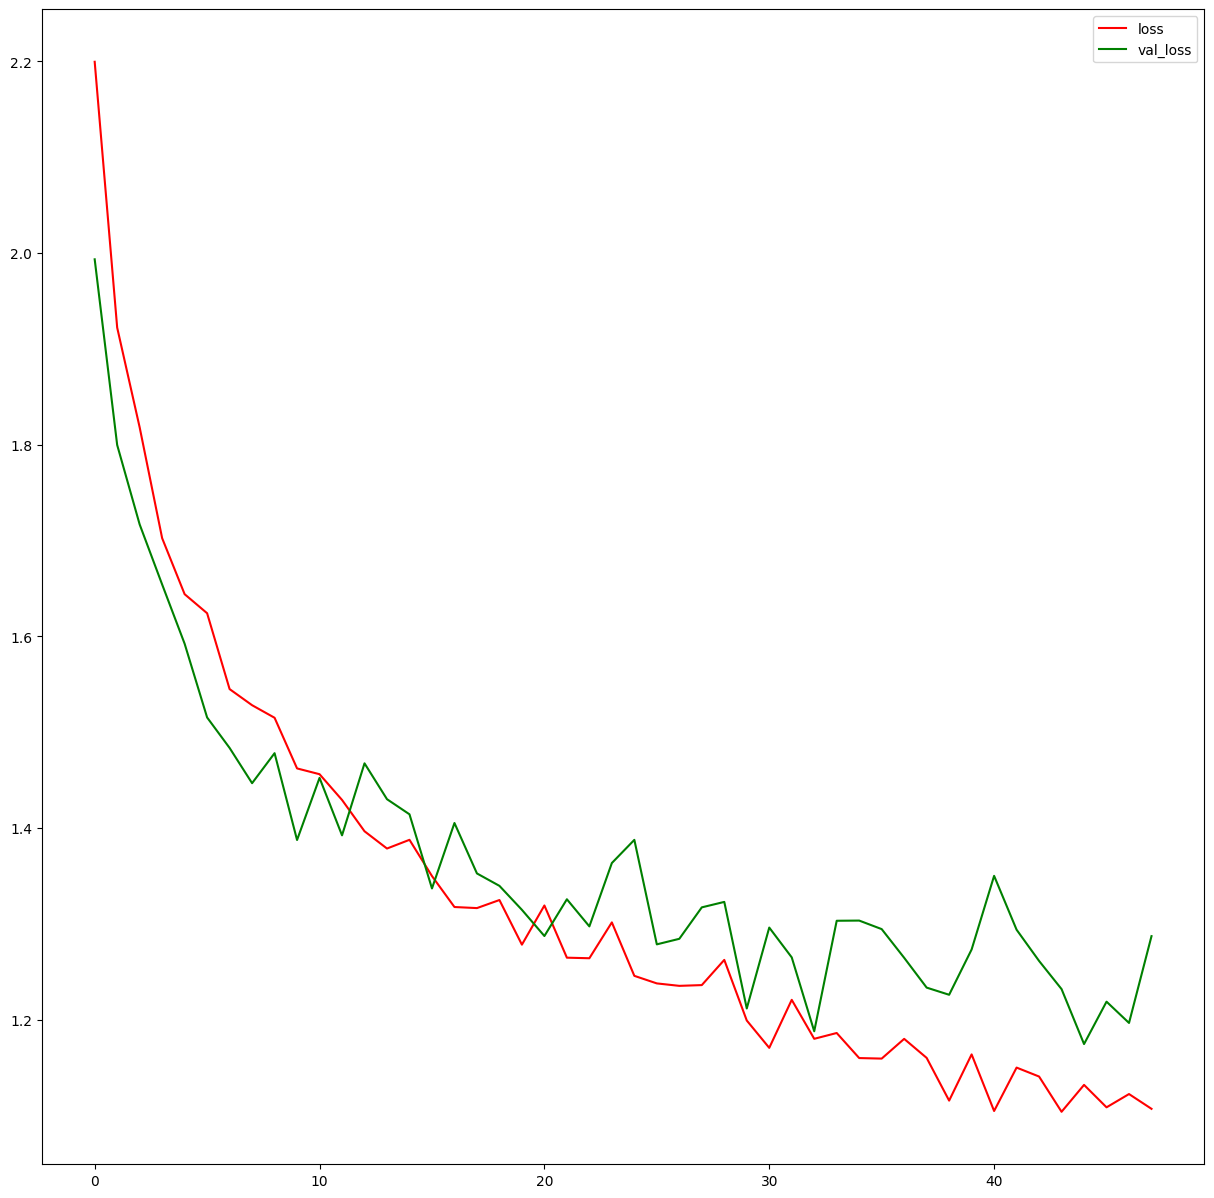

In [2]:
with open('ConvNeXtLarge_training_history.pkl', 'rb') as file:
        loaded_history = pickle.load(file)

fig, ax = plt.subplots(figsize=(15, 15))
losses = pd.DataFrame(loaded_history)
losses[['loss','val_loss']].plot(color=['red', 'green'], ax=ax)
plt.show()

In [3]:
data_dir = "../dataset-original"

In [4]:
img_height, img_width = 224,224
tf.random.set_seed(42)
np.random.seed(42)


validation_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.5, 1.5],
    channel_shift_range=20,
    validation_split=0.2
)

validation_generator = validation_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    shuffle=False,
    class_mode='categorical',
    subset='validation'
)

Found 503 images belonging to 6 classes.


In [5]:
class_names = list(validation_generator.class_indices.keys())
class_names

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

In [6]:
best_model_location = "./ConvNeXtLarge_checkpoints/model_checkpoint_33.h5"
input_shape = (img_height, img_width, 3)
inputs = Input(shape=input_shape)

base_model = ConvNeXtLarge(weights='imagenet', include_top=False, input_shape=input_shape)

splitter = len(base_model.layers) - 25

for layer in base_model.layers[:splitter]:
    layer.trainable = False

for layer in base_model.layers[splitter:]:
    layer.trainable = True

x = base_model(inputs, training=False)
x = GlobalAveragePooling2D(name="avg_pool")(x)
x = BatchNormalization()(x)
x = Flatten()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
outputs = Dense(len(validation_generator.class_indices), activation='softmax')(x)

# Combine the base model with custom top layers
model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

model.load_weights(best_model_location)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 convnext_large (Functional)  (None, 7, 7, 1536)       196230336 
                                                                 
 avg_pool (GlobalAveragePool  (None, 1536)             0         
 ing2D)                                                          
                                                                 
 batch_normalization (BatchN  (None, 1536)             6144      
 ormalization)                                                   
                                                                 
 flatten (Flatten)           (None, 1536)              0         
                                                                 
 dense (Dense)               (None, 256)               393472

In [7]:
predictions = model.predict(validation_generator)

16/16 [==============================] - 63s 3s/step


In [8]:
predicted_classes = np.argmax(predictions, axis=1)
true_classes = validation_generator.classes

In [9]:
conf_matrix = confusion_matrix(true_classes, predicted_classes)

In [10]:
accuracy = accuracy_score(true_classes, predicted_classes)
print("Accuracy of the best model: {:.2f}%".format(accuracy * 100))

Accuracy of the best model: 54.27%


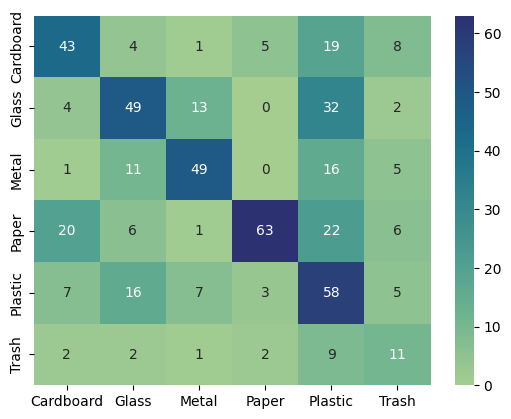

In [11]:
import seaborn as sns

class_details = {
    0: "Cardboard",
    1: "Glass",
    2: "Metal",
    3: "Paper",
    4: "Plastic",
    5: "Trash"
}
df_cm = pd.DataFrame(conf_matrix)
sns.heatmap(df_cm, annot=True, xticklabels=class_details.values(), yticklabels=class_details.values(), cmap='crest')
plt.show()

In [12]:
classification_scores = classification_report(true_classes, predicted_classes, target_names=validation_generator.class_indices.keys(), output_dict=True)
classification_scores_df = pd.DataFrame(classification_scores).transpose()
classification_scores_df

,precision,recall,f1-score,support
cardboard,0.558442,0.537500,0.547771,80.000000
glass,0.556818,0.490000,0.521277,100.000000
metal,0.680556,0.597561,0.636364,82.000000
paper,0.863014,0.533898,0.659686,118.000000
plastic,0.371795,0.604167,0.460317,96.000000
trash,0.297297,0.407407,0.343750,27.000000
accuracy,0.542744,0.542744,0.542744,0.542744
macro avg,0.554654,0.528422,0.528194,503.000000
weighted avg,0.599836,0.542744,0.555558,503.000000


1/1 [==============================] - 0s 107ms/step


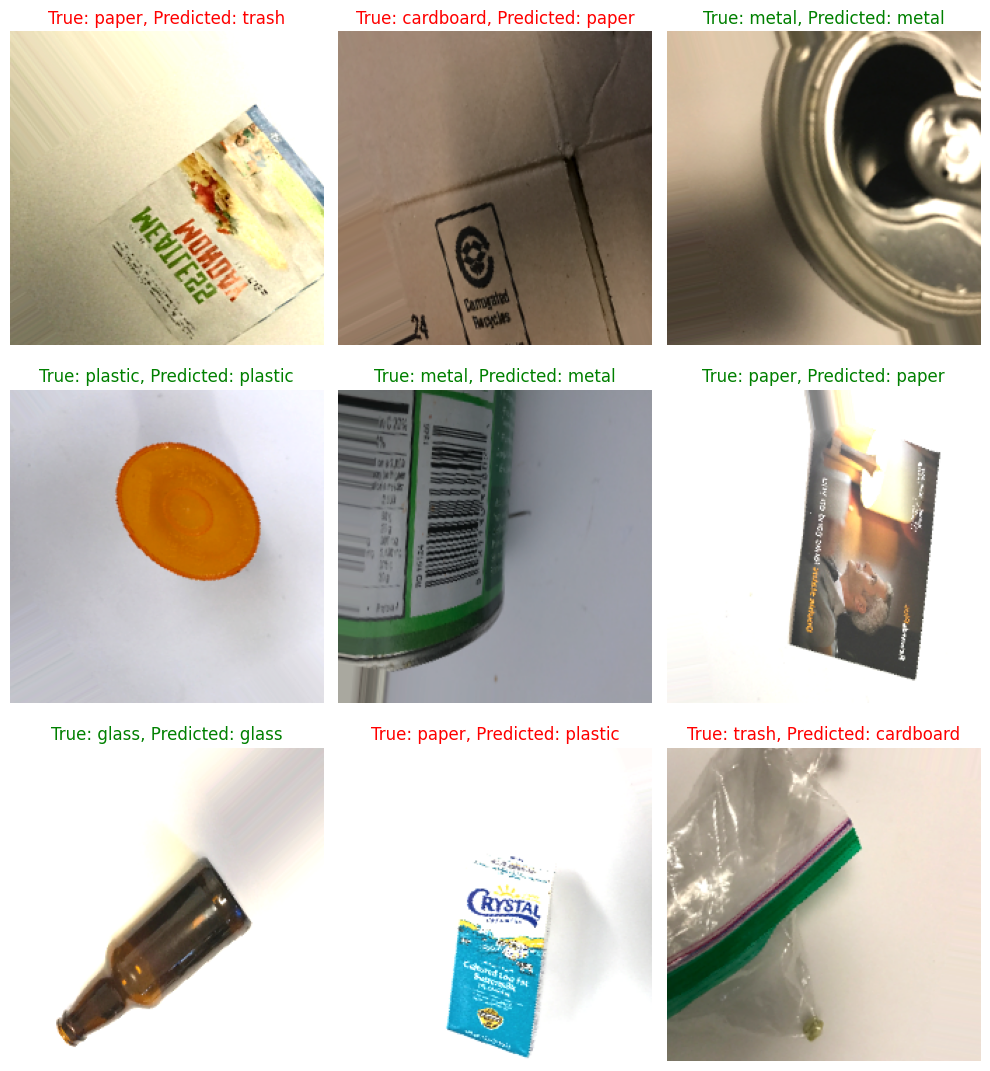

In [13]:
num_samples = 9
random_indices = np.random.choice(len(validation_generator), size=num_samples, replace=False)

sample_images = []
sample_labels = []

for idx in random_indices:
    batch = validation_generator[idx]
    image = batch[0][0]
    label_index = np.argmax(batch[1][0])
    sample_images.append(image)
    sample_labels.append(label_index)

class_names = list(validation_generator.class_indices.keys())

# Plot images with true and predicted labels
fig, axs = plt.subplots(3, 3, figsize=(10, 11))

for ax, image, true_label_index in zip(axs.flat, sample_images, sample_labels):
    true_label_name = class_names[true_label_index]
    predicted_label_probs = model.predict(np.expand_dims(image, axis=0))[0]
    predicted_label_index = np.argmax(predicted_label_probs)
    predicted_label_name = class_names[predicted_label_index]
    label_color = 'green' if predicted_label_index == true_label_index else 'red'

    ax.imshow(image)
    ax.set_title(f"True: {true_label_name}, Predicted: {predicted_label_name}", color=label_color)
    ax.axis('off')

plt.tight_layout()
plt.show()


### Real World Test

1/1 [==============================] - 0s 102ms/step


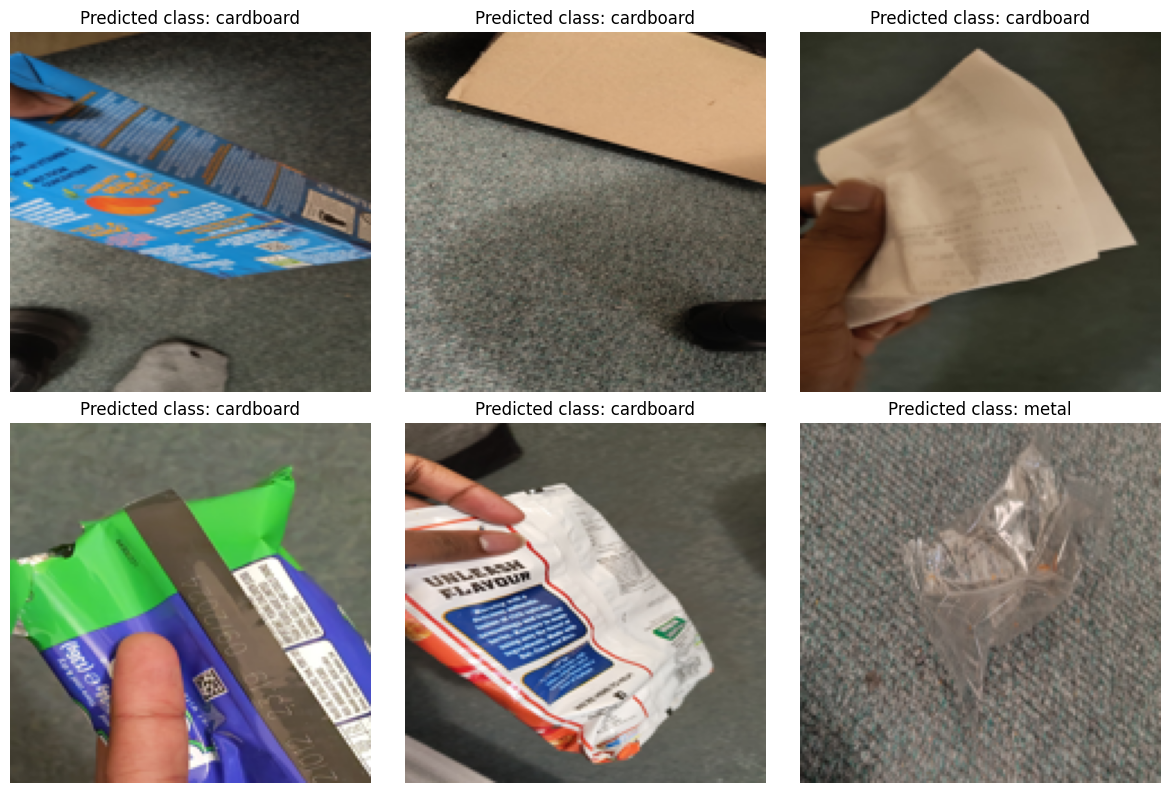

In [14]:
from PIL import Image
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

folder_path = '../live_samples/'

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))

for i, filename in enumerate(os.listdir(folder_path)[:6]):
    if filename.endswith(".jpg") or filename.endswith(".jpeg"):
        img_path = os.path.join(folder_path, filename)
        img = Image.open(img_path)
        img = img.resize((160, 160))
        img_array = np.array(img, dtype=np.float32)
        img_array = np.expand_dims(img_array, axis=0)
        img_array /= 255.  # Normalize pixel values to [0, 1] as float32

        predictions = model.predict(img_array)

        predicted_class_index = np.argmax(predictions[0])
        predicted_class_name = class_names[predicted_class_index]

        ax = axs[i // 3, i % 3]
        ax.imshow(img)
        ax.set_title(f"Predicted class: {predicted_class_name}")
        ax.axis('off')

plt.tight_layout()
plt.show()
